# Load library and data

In [45]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/DA VEF 2022/Final project/Raw Data/Basket&Demand.csv', header = None)
df.columns = ['order_id','product_id','order_item_id','category','purchase_date']

In [3]:
df.head()

,order_id,product_id,order_item_id,category,purchase_date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,cool_stuff,2017-09-13 08:59:02.0000000
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,pet_shop,2017-04-26 10:53:06.0000000
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,furniture_decor,2018-01-14 14:33:31.0000000
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,perfumery,2018-08-08 10:00:35.0000000
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,garden_tools,2017-02-04 13:57:51.0000000


#Preprocessing

## Find missing data

In [4]:
df_na = (df.isnull().sum() / len(df)) * 100 # percentage of missing entries

df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate
category,1.444296


In [5]:
#Assume that we will accept columns with missing rate less than 5%
threshold =  5
missing_col_drop = list(missing_data[missing_data.miss_rate > threshold].index)
missing_col_drop

[]

## Fill missing data

In [6]:
modes = df.mode()
df = df.fillna(modes.to_dict(orient='records')[0])

In [7]:
df_na = (df.isnull().sum() / len(df)) * 100 # percentage of missing entries

df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head()

,miss_rate


So in this case, no data is drop

#EDA

## Items frequency

###By category

In [8]:
cat = df.groupby('category').agg({'order_id':'count','product_id':'nunique'}).reset_index()
cat.columns = ['category','no_order','no_product']
top_20 = cat.sort_values(by='no_order', ascending = False).head(20)

Text(0.5, 1.0, 'Number of product')

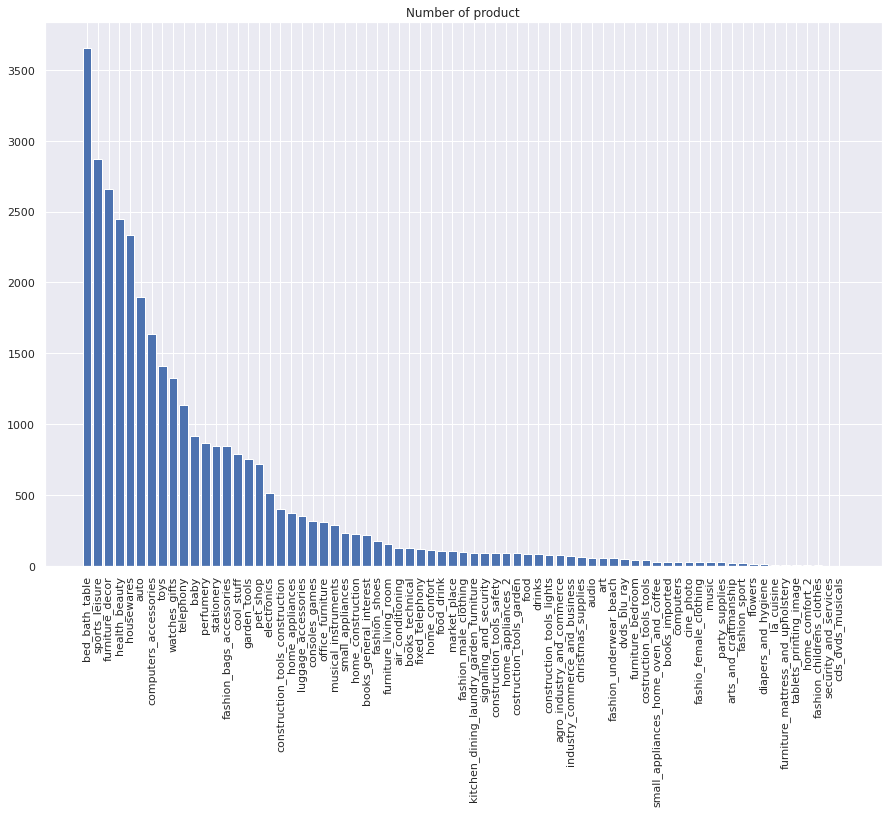

In [9]:
sorted_cat = cat.sort_values('no_product',ascending = False)
plt.bar(sorted_cat['category'], height= sorted_cat['no_product'])
plt.xticks(rotation=90)
plt.title('Number of product')

Text(0.5, 1.0, 'Top 20 favorite categories')

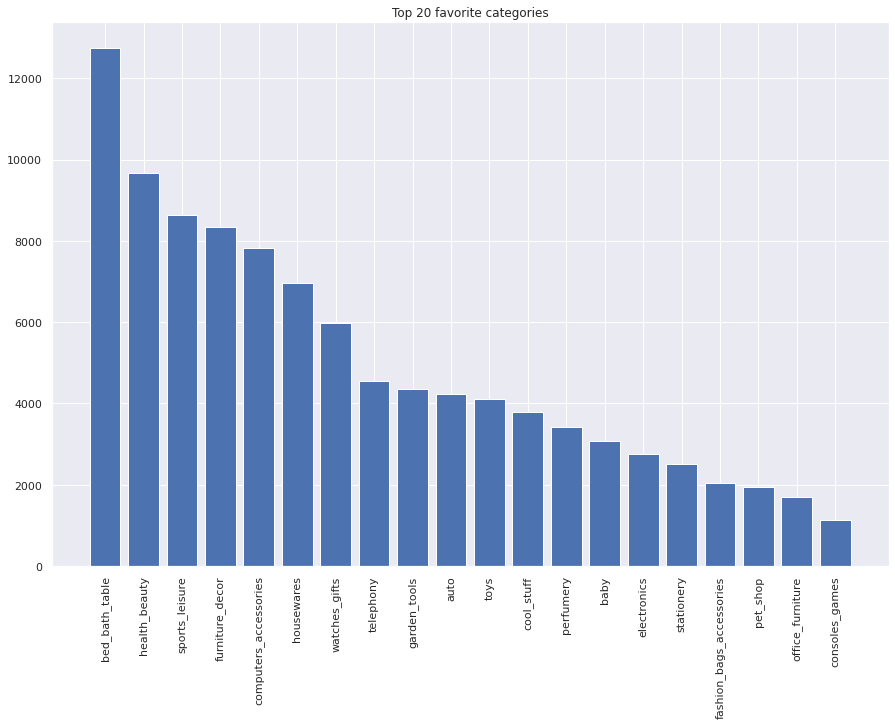

In [10]:
plt.bar(top_20['category'], height= top_20['no_order'])
plt.xticks(rotation=90)
plt.title('Top 20 favorite categories')

###By product

In [11]:
pro = df.groupby('product_id')['order_id'].count().reset_index()
pro.columns = ['product','freq']
pro

,product,freq
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,2
32947,fff81cc3158d2725c0655ab9ba0f712c,1
32948,fff9553ac224cec9d15d49f5a263411f,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,5


In [12]:
top_50_products = pro.sort_values('freq',ascending = False).head(50)

Text(0.5, 1.0, 'Product Frequency')

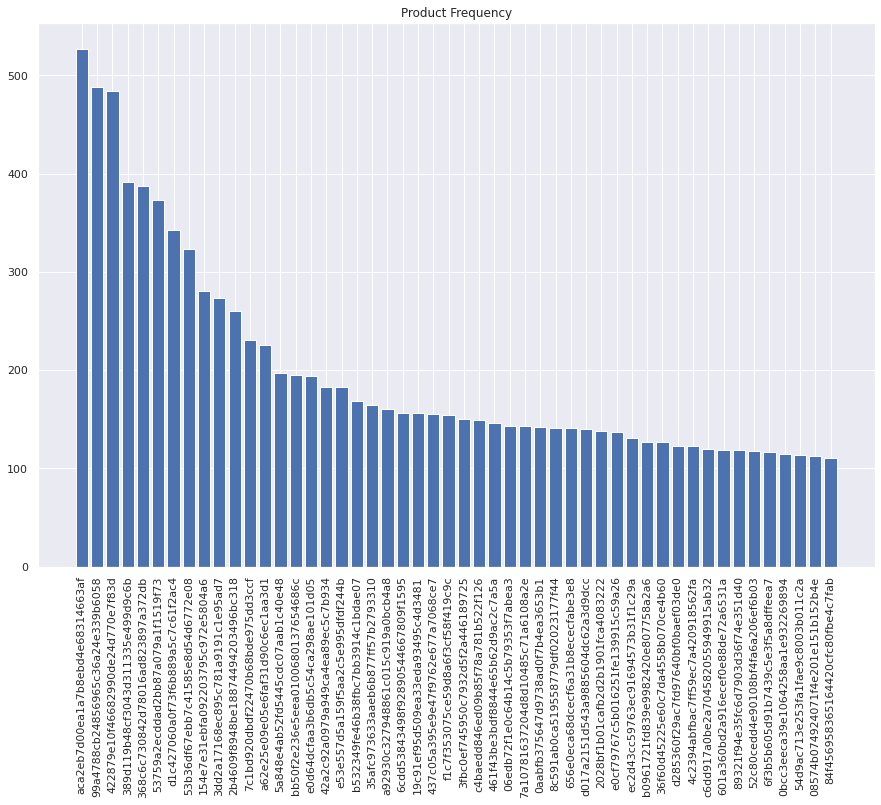

In [13]:
plt.bar(top_50_products['product'], height= top_50_products['freq'])
plt.xticks(rotation=90)
plt.title('Product Frequency')

#Function to encode

In [14]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Basket group by category

In [15]:
basket = df.groupby(['order_id','category'])['order_item_id']\
                                    .sum() \
                                    .unstack() \
                                    .reset_index() \
                                    .fillna(0) \
                                    .set_index('order_id')

In [16]:
basket.describe()

category,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,...,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000
mean,0.002686,0.003669,0.002331,0.000264,0.003882,0.049470,0.034733,0.157805,0.006172,0.000689,...,0.000020,0.003112,0.007551,0.000780,0.100663,0.028429,0.000902,0.052308,0.045051,0.066832
std,0.109466,0.121423,0.082372,0.018562,0.070581,0.737136,0.354224,0.720894,0.106031,0.033685,...,0.004502,0.152814,0.123357,0.028993,0.487644,0.238308,0.034424,0.544415,0.277115,0.441010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.000000,28.000000,21.000000,3.000000,6.000000,210.000000,78.000000,66.000000,10.000000,3.000000,...,1.000000,21.000000,21.000000,3.000000,28.000000,21.000000,3.000000,105.000000,21.000000,78.000000


In [17]:
basket_sets = basket.applymap(encode_units)
basket_sets = basket_sets[basket_sets.sum(axis = 1) > 1]
basket_sets

category,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
002f98c0f7efd42638ed6100ca699b42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
005d9a5423d47281ac463a968b3936fb,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
014405982914c2cde2796ddcf0b8703d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
01b1a7fdae9ad1837d6ab861705a1fa5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
01cce1175ac3c4a450e3a0f856d02734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe678293ea3bb6607a15b2e320e91722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ff00a56fe9475a175cd651d77c707a09,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ff40f38705c95a8eceea1a0db29bff66,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames = True)
frequent_itemsets.sort_values(by = 'support', ascending = False ).head()

,support,itemsets
2,0.324359,(bed_bath_table)
13,0.264103,(furniture_decor)
19,0.148718,(housewares)
1,0.119231,(baby)
15,0.093590,(garden_tools)


In [19]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.1)
rules.sort_values(["confidence"],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(home_confort),(bed_bath_table),0.064103,0.324359,0.055128,0.860000,2.651383,0.034336,4.826007
22,(construction_tools_lights),(furniture_decor),0.023077,0.264103,0.014103,0.611111,2.313916,0.008008,1.892308
26,(home_construction),(furniture_decor),0.033333,0.264103,0.016667,0.500000,1.893204,0.007863,1.471795
11,(fashion_bags_accessories),(bed_bath_table),0.025641,0.324359,0.012821,0.500000,1.541502,0.004504,1.351282
32,(perfumery),(health_beauty),0.035897,0.092308,0.015385,0.428571,4.642857,0.012071,1.588462
6,(toys),(baby),0.065385,0.119231,0.024359,0.372549,3.124605,0.016563,1.403726
12,(furniture_decor),(bed_bath_table),0.264103,0.324359,0.093590,0.354369,1.092521,0.007926,1.046482
2,(cool_stuff),(baby),0.085897,0.119231,0.025641,0.298507,2.503611,0.015399,1.255565
18,(housewares),(bed_bath_table),0.148718,0.324359,0.043590,0.293103,0.903639,-0.004648,0.955785
13,(bed_bath_table),(furniture_decor),0.324359,0.264103,0.093590,0.288538,1.092521,0.007926,1.034345


## Should appear rules (Complementary goods)

In [20]:
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = rules[rules['lift']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
pivot

consequents_,baby,bed_bath_table,computers_accessories,construction_tools_lights,cool_stuff,fashion_bags_accessories,furniture_decor,garden_tools,health_beauty,home_confort,home_construction,housewares,perfumery,sports_leisure,toys
antecedents_,,,,,,,,,,,,,,,
baby,NaN,NaN,NaN,NaN,2.503611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.124605
bed_bath_table,NaN,NaN,NaN,NaN,NaN,1.541502,1.092521,NaN,NaN,2.651383,NaN,NaN,NaN,NaN,NaN
computers_accessories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.849315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
construction_tools_lights,NaN,NaN,NaN,NaN,NaN,NaN,2.313916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cool_stuff,2.503611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fashion_bags_accessories,NaN,1.541502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
furniture_decor,NaN,1.092521,NaN,2.313916,NaN,NaN,NaN,NaN,NaN,NaN,1.893204,NaN,NaN,NaN,NaN
garden_tools,NaN,NaN,1.849315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.013226,NaN,NaN,NaN
health_beauty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.642857,2.106481,NaN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


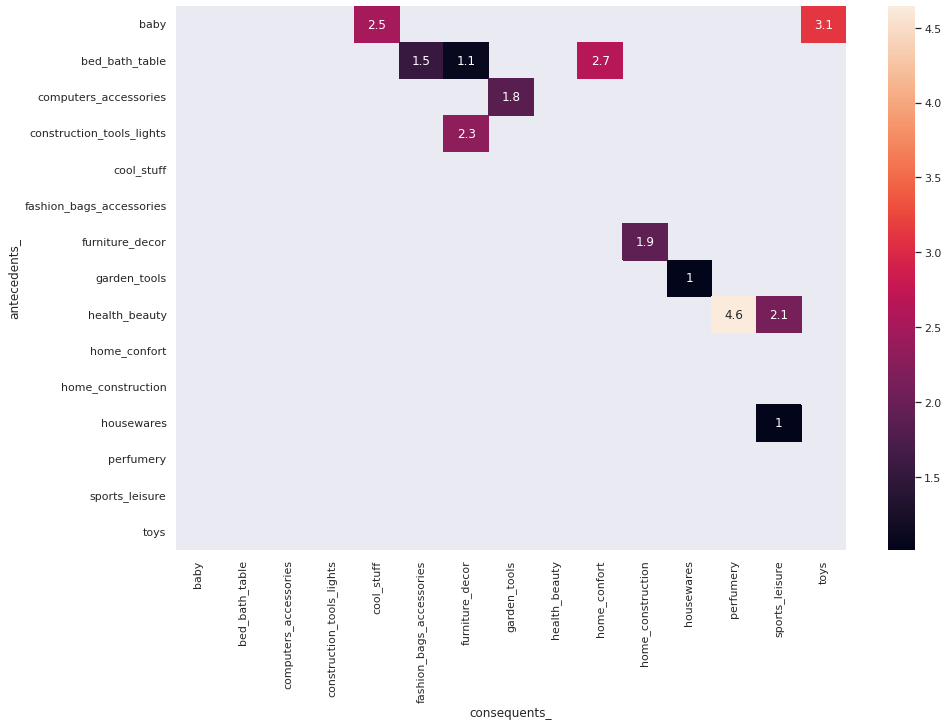

In [21]:
upper = pivot.where(np.triu(np.ones(pivot.shape), k=1).astype(np.bool))

sns.heatmap(upper, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

##Should not appear rules (Substitute goods)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


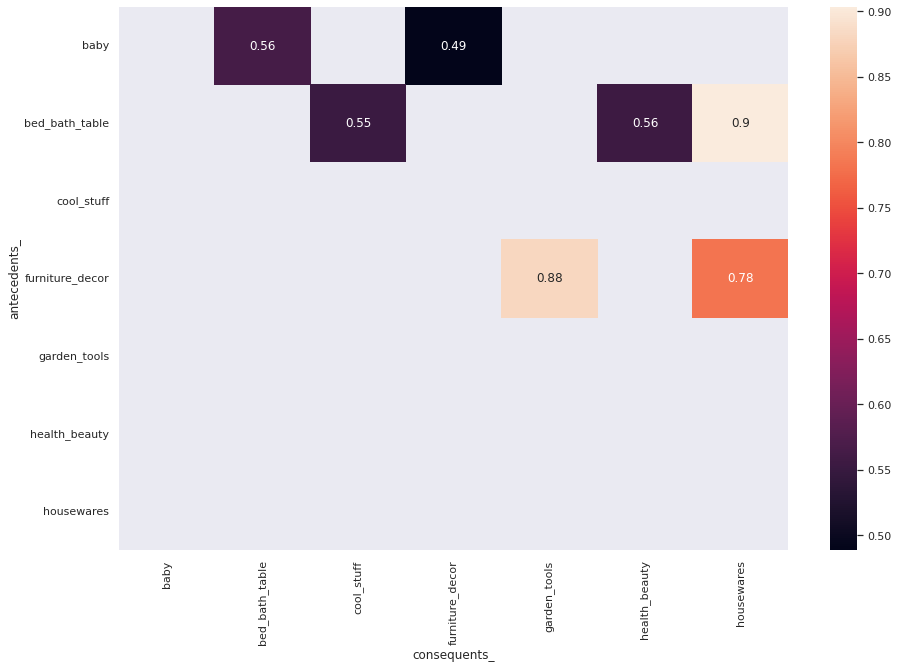

In [22]:
pivot_n = rules[rules['lift']<1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
upper_n = pivot_n.where(np.triu(np.ones(pivot_n.shape), k=1).astype(np.bool))

sns.heatmap(upper_n, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#Product's rules




In [23]:
def product_rule(antecedents, consequents, sorted_by = ['lift','confidence'], asc = False, top_k = 10 ):
  basket_product = df[(df['category'] == antecedents) | 
                                (df['category'] == consequents)]\
                                    .groupby(['order_id','product_id'])['order_item_id']\
                                    .sum() \
                                    .unstack() \
                                    .reset_index() \
                                    .fillna(0) \
                                    .set_index('order_id')


  basket_product_sets = basket_product.applymap(encode_units)
  basket_product_sets = basket_product_sets[basket_product_sets.sum(axis = 1) > 1]
  frequent_itemsets_product = apriori(basket_product_sets, min_support=0.005, use_colnames = True)
  rules_product = association_rules(frequent_itemsets_product, metric='confidence', min_threshold=0.5)
  return rules_product.sort_values(by = sorted_by, ascending = asc).head(top_k)

## Rule: Health_beauty --> Perfumery

In [24]:
product_rule('health_beauty','perfumery')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(189e539d996a9b8ba4bba1a140a024a7),(a669398f595527fc03acc1ebda6b3cce),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
14,(a669398f595527fc03acc1ebda6b3cce),(189e539d996a9b8ba4bba1a140a024a7),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
17,(2ae501b303a5a8e6f75c8c36f366b2d5),(d8c0c707d3724304033f593878cbf1e6),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
18,(d8c0c707d3724304033f593878cbf1e6),(2ae501b303a5a8e6f75c8c36f366b2d5),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
22,(3e7d7087ff8bbc0e9568b56ba3504a34),(8ee57a1f636eb2e009706bbdb0818ecc),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
23,(8ee57a1f636eb2e009706bbdb0818ecc),(3e7d7087ff8bbc0e9568b56ba3504a34),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
35,(e2f1ccf86759df28dd1e9f2e0e3242d4),(eb9b44e05684527fbfdfd0ff5cb86250),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
36,(eb9b44e05684527fbfdfd0ff5cb86250),(e2f1ccf86759df28dd1e9f2e0e3242d4),0.007937,0.007937,0.007937,1.000000,126.0,0.007874,inf
25,(521527593ca1726b992318e034dd5690),(a25583531530c0913ea4dee2c5c73685),0.007937,0.011905,0.007937,1.000000,84.0,0.007842,inf
26,(a25583531530c0913ea4dee2c5c73685),(521527593ca1726b992318e034dd5690),0.011905,0.007937,0.007937,0.666667,84.0,0.007842,2.97619


## Rule: Bed_bath_table --> Home_confort

In [25]:
product_rule('bed_bath_table','home_confort')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fb783e3e545937820b57fe539b2c5a6c),(0fa81e7123fd0ebe03adbbe99d912827),0.005908,0.013294,0.005908,1.000000,75.222222,0.005830,inf
4,(84f456958365164420cfc80fbe4c7fab),(64fb265487de2238627ce43fe8a67efc),0.010340,0.008863,0.005908,0.571429,64.476190,0.005817,2.312654
5,(64fb265487de2238627ce43fe8a67efc),(84f456958365164420cfc80fbe4c7fab),0.008863,0.010340,0.005908,0.666667,64.476190,0.005817,2.968981
9,(c211ff3068fcd2f8898192976d8b3a32),(f4d705aa95ccca448e5b0deb6e5290ba),0.010340,0.010340,0.005908,0.571429,55.265306,0.005802,2.309207
10,(f4d705aa95ccca448e5b0deb6e5290ba),(c211ff3068fcd2f8898192976d8b3a32),0.010340,0.010340,0.005908,0.571429,55.265306,0.005802,2.309207
7,(ad0a798e7941f3a5a2fb8139cb62ad78),(946344697156947d846d27fe0d503033),0.013294,0.014771,0.008863,0.666667,45.133333,0.008666,2.955687
6,(946344697156947d846d27fe0d503033),(ad0a798e7941f3a5a2fb8139cb62ad78),0.014771,0.013294,0.008863,0.600000,45.133333,0.008666,2.466765
3,(4d0ec1e9b95fb62f9a1fbe21808bf3b1),(9ad75bd7267e5c724cb42c71ac56ca72),0.013294,0.019202,0.008863,0.666667,34.717949,0.008607,2.942393
1,(35afc973633aaeb6b877ff57b2793310),(99a4788cb24856965c36a24e339b6058),0.053176,0.070901,0.042836,0.805556,11.361690,0.039066,4.778223
2,(99a4788cb24856965c36a24e339b6058),(35afc973633aaeb6b877ff57b2793310),0.070901,0.053176,0.042836,0.604167,11.361690,0.039066,2.391977


#Conclusion

Lift will tell us if the product A and B both appear they will multiply the probability of customers purchasing both by lift (times). 



Complimentary goods: Due to category rules we should recommend health_beauty products if customers already purchase perfumery and vice versa. Besides, there are many couple of categories that would enhance probability customers buying A's products along with B's product such as bed_bath_table and home_confront,...

Substitute goods: We should avoid (baby, furniture_decor),(bed_bath_table,cool_stuff),... appear simultaneously beacause it will decrease the probability of buying. 

To have a detail information about product rules among categories, we can use function product_rule to find out. Because all products haven't named obviously in this case so I won't mention this rule in detailed. 

# Addition: Demand prediction model

Desire input: Related items last month sales*lift of related items - month - y

##Preprocessing

###Prepare Data

In [26]:
com = pd.DataFrame(pivot['bed_bath_table'])
sub = pd.DataFrame(pivot_n['bed_bath_table'])
lift = pd.concat([com,sub])
lift = lift.dropna(axis = 0)
lift['category'] = lift.index
lift

,bed_bath_table,category
antecedents_,,
fashion_bags_accessories,1.541502,fashion_bags_accessories
furniture_decor,1.092521,furniture_decor
home_confort,2.651383,home_confort
baby,0.563560,baby
cool_stuff,0.552180,cool_stuff
health_beauty,0.556653,health_beauty
housewares,0.903639,housewares


In [27]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['month_year'] = df['purchase_date'].apply(lambda x: dt.strftime(x, format = '%m/%Y'))
df

,order_id,product_id,order_item_id,category,purchase_date,month_year
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,cool_stuff,2017-09-13 08:59:02,09/2017
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,pet_shop,2017-04-26 10:53:06,04/2017
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,furniture_decor,2018-01-14 14:33:31,01/2018
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,perfumery,2018-08-08 10:00:35,08/2018
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,garden_tools,2017-02-04 13:57:51,02/2017
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1,housewares,2018-04-23 13:57:06,04/2018
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1,computers_accessories,2018-07-14 10:26:46,07/2018
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1,sports_leisure,2017-10-23 17:07:56,10/2017
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1,computers_accessories,2017-08-14 23:02:59,08/2017


In [28]:
month_order = df.groupby(['category','month_year'])['order_item_id'].sum().reset_index()
month_order.columns = ['category','month_year','no_items_sold']
lift_metrix = month_order.merge(lift,how = 'left', on = 'category').dropna(axis = 0)
lift_metrix.columns = ['category','month_year','no_items_sold','lift']
lift_metrix['lift_items'] = lift_metrix['lift']*lift_metrix['no_items_sold']
lift_metrix

,category,month_year,no_items_sold,lift,lift_items
105,baby,01/2017,57,0.563560,32.122912
106,baby,01/2018,242,0.563560,136.381487
107,baby,02/2017,37,0.563560,20.851715
108,baby,02/2018,186,0.563560,104.822134
109,baby,03/2017,45,0.563560,25.360194
...,...,...,...,...,...
876,housewares,09/2017,299,0.903639,270.188088
877,housewares,10/2016,16,0.903639,14.458225
878,housewares,10/2017,360,0.903639,325.310072
879,housewares,11/2017,541,0.903639,488.868747


In [29]:
lift_pivot = pd.pivot_table(lift_metrix,index = 'month_year', columns = 'category', values = 'lift_items', aggfunc = 'sum')
lift_pivot['date'] = lift_pivot.index
lift_pivot.head()

category,baby,cool_stuff,fashion_bags_accessories,furniture_decor,health_beauty,home_confort,housewares,date
month_year,,,,,,,,
01/2017,32.122912,28.713350,61.660079,300.443225,48.985507,NaN,34.338285,01/2017
01/2018,136.381487,176.145360,215.810277,926.457654,396.893939,53.027668,385.853891,01/2018
02/2017,20.851715,39.204767,67.826087,356.161787,100.197628,7.954150,94.882104,02/2017
02/2018,104.822134,106.570704,175.731225,621.644346,424.726614,60.981818,454.530462,02/2018
03/2017,25.360194,69.574656,114.071146,462.136306,133.040184,39.770751,225.006133,03/2017


In [30]:
lift_pivot.shape

(23, 8)

In [31]:
bed_bath_table = month_order[month_order['category'] == 'bed_bath_table']
bed_bath_table.head()

,category,month_year,no_items_sold
126,bed_bath_table,01/2017,68
127,bed_bath_table,01/2018,1356
128,bed_bath_table,02/2017,266
129,bed_bath_table,02/2018,952
130,bed_bath_table,03/2017,417


In [32]:
metrix = lift_pivot.merge(bed_bath_table, how = 'left', on = 'month_year')
metrix

,month_year,baby,cool_stuff,fashion_bags_accessories,furniture_decor,health_beauty,home_confort,housewares,date,category,no_items_sold
0,01/2017,32.122912,28.713350,61.660079,300.443225,48.985507,NaN,34.338285,01/2017,bed_bath_table,68.0
1,01/2018,136.381487,176.145360,215.810277,926.457654,396.893939,53.027668,385.853891,01/2018,bed_bath_table,1356.0
2,02/2017,20.851715,39.204767,67.826087,356.161787,100.197628,7.954150,94.882104,02/2017,bed_bath_table,266.0
3,02/2018,104.822134,106.570704,175.731225,621.644346,424.726614,60.981818,454.530462,02/2018,bed_bath_table,952.0
4,03/2017,25.360194,69.574656,114.071146,462.136306,133.040184,39.770751,225.006133,03/2017,bed_bath_table,417.0
5,03/2018,131.309448,154.610347,234.308300,954.863195,410.810277,58.330435,489.772387,03/2018,bed_bath_table,1138.0
6,04/2017,32.122912,68.470297,83.241107,268.760121,112.444005,53.027668,241.271637,04/2017,bed_bath_table,403.0
7,04/2018,184.284075,131.418795,201.936759,890.404467,449.219368,58.330435,499.712417,04/2018,bed_bath_table,1043.0
8,05/2017,66.500064,143.566751,195.770751,375.827161,177.015810,108.706719,343.382854,05/2017,bed_bath_table,527.0
9,05/2018,160.614561,105.466344,184.980237,896.959592,494.308300,74.238735,806.046068,05/2018,bed_bath_table,1006.0


###Remove missing data

In [33]:
metrix = metrix.dropna(axis = 0)

###Remove highly correlated variable

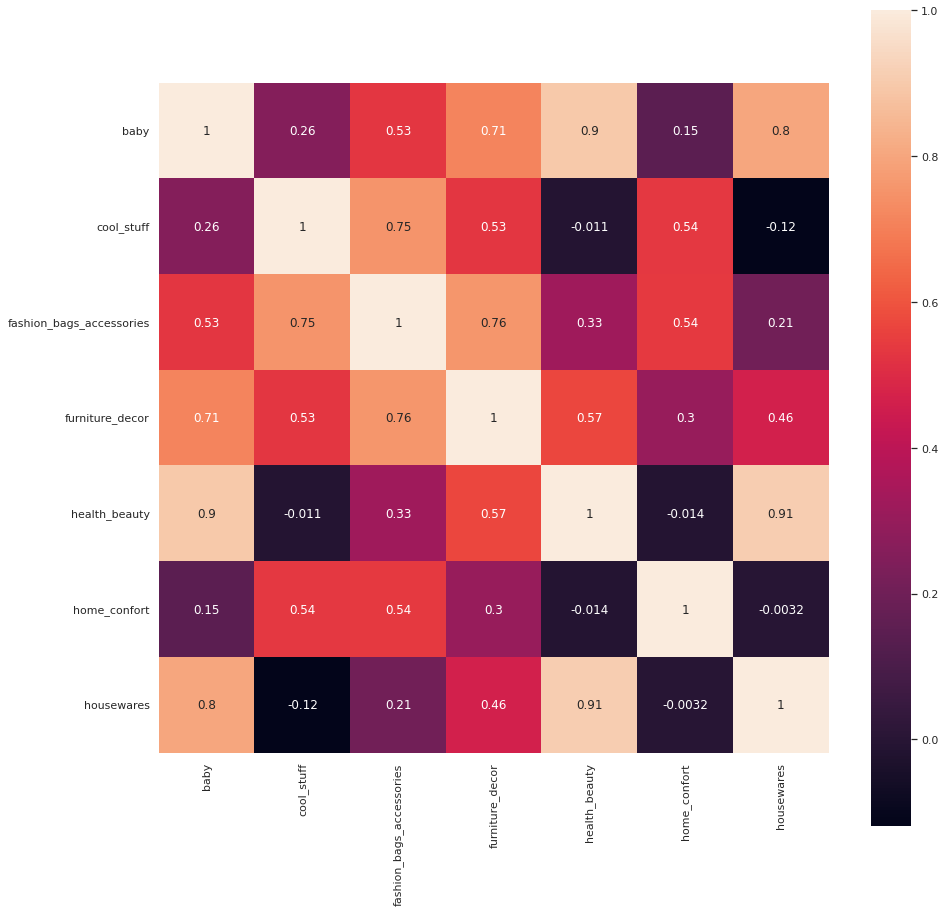

In [34]:
corr_matrix = metrix.drop(columns=['no_items_sold'])._get_numeric_data().corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

In [35]:
corr_threshold = 0.8

corr_matrix = corr_matrix.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]
to_drop_corr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


['health_beauty', 'housewares']

In [36]:
train = metrix.drop(columns=to_drop_corr)
train.head()

,month_year,baby,cool_stuff,fashion_bags_accessories,furniture_decor,home_confort,date,category,no_items_sold
1,01/2018,136.381487,176.145360,215.810277,926.457654,53.027668,01/2018,bed_bath_table,1356.0
2,02/2017,20.851715,39.204767,67.826087,356.161787,7.954150,02/2017,bed_bath_table,266.0
3,02/2018,104.822134,106.570704,175.731225,621.644346,60.981818,02/2018,bed_bath_table,952.0
4,03/2017,25.360194,69.574656,114.071146,462.136306,39.770751,03/2017,bed_bath_table,417.0
5,03/2018,131.309448,154.610347,234.308300,954.863195,58.330435,03/2018,bed_bath_table,1138.0


###Scaling numerical variable using MinMaxScaler

In [37]:
num_cols = train.drop(columns=['no_items_sold']).select_dtypes(include='number').columns
print(num_cols)
train[num_cols].head()

Index(['baby', 'cool_stuff', 'fashion_bags_accessories', 'furniture_decor',
       'home_confort'],
      dtype='object')


,baby,cool_stuff,fashion_bags_accessories,furniture_decor,home_confort
1,136.381487,176.145360,215.810277,926.457654,53.027668
2,20.851715,39.204767,67.826087,356.161787,7.954150
3,104.822134,106.570704,175.731225,621.644346,60.981818
4,25.360194,69.574656,114.071146,462.136306,39.770751
5,131.309448,154.610347,234.308300,954.863195,58.330435


In [38]:
scaler = MinMaxScaler() 

scaled_df = scaler.fit_transform(train[num_cols])

train[num_cols] = scaled_df

train.head()

,month_year,baby,cool_stuff,fashion_bags_accessories,furniture_decor,home_confort,date,category,no_items_sold
1,01/2018,0.706897,0.995984,0.545455,0.582205,0.309091,01/2018,bed_bath_table,1356.0
2,02/2017,0.000000,0.000000,0.000000,0.077369,0.000000,02/2017,bed_bath_table,266.0
3,02/2018,0.513793,0.489960,0.397727,0.312379,0.363636,02/2018,bed_bath_table,952.0
4,03/2017,0.027586,0.220884,0.170455,0.171180,0.218182,03/2017,bed_bath_table,417.0
5,03/2018,0.675862,0.839357,0.613636,0.607350,0.345455,03/2018,bed_bath_table,1138.0


###Final data

In [39]:
train['month'] = pd.to_datetime(train['date']).apply(lambda x: dt.strftime(x, format = '%m')).astype('int')
train_final = train.drop(['month_year','date','category'], axis =1)
train_final.head()

,baby,cool_stuff,fashion_bags_accessories,furniture_decor,home_confort,no_items_sold,month
1,0.706897,0.995984,0.545455,0.582205,0.309091,1356.0,1
2,0.000000,0.000000,0.000000,0.077369,0.000000,266.0,2
3,0.513793,0.489960,0.397727,0.312379,0.363636,952.0,2
4,0.027586,0.220884,0.170455,0.171180,0.218182,417.0,3
5,0.675862,0.839357,0.613636,0.607350,0.345455,1138.0,3


##Train a linear model

In [40]:
test_size_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(train_final.drop('no_items_sold', axis =1), train_final['no_items_sold'], test_size=0.3, random_state=100)
X_train.head()

,baby,cool_stuff,fashion_bags_accessories,furniture_decor,home_confort,month
22,0.393103,0.827309,0.602273,0.260155,0.200000,12
7,1.000000,0.670683,0.494318,0.550290,0.345455,4
10,0.186207,0.538153,0.255682,0.078337,0.290909,6
12,0.341379,0.686747,0.289773,0.175048,0.981818,7
6,0.068966,0.212851,0.056818,0.000000,0.309091,4


In [41]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [42]:
print(f'MSE       = {mean_squared_error(y_test, y_pred):.2f}')

print(f'R-squared = {r2_score(y_test, y_pred):.4f}')

MSE       = 19896.55
R-squared = 0.8021


In [50]:
est = sm.OLS(y_train, X_train)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:          no_items_sold   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              44.31
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    3.21e-05
Time:                        02:27:56   Log-Likelihood:                         -82.677
No. Observations:                  13   AIC:                                      177.4
Df Residuals:                       7   BIC:                                      180.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


###New model using selectKbest

In [43]:
selectkbest = SelectKBest(f_regression, k = 5)
selectkbest.fit(X_train, y_train)
x_train_selected = selectkbest.transform(X_train)
new_model = LinearRegression()
new_model.fit(x_train_selected,y_train)

x_test_selected = selectkbest.transform(X_test)
y_pred_selected = new_model.predict(x_test_selected)

In [44]:
# R-squared
print(f'R-squared = {r2_score(y_test,y_pred_selected):.4f}')
# Mean Squared Error
print(f'MSE       = {mean_squared_error(y_test,y_pred_selected):.2f}')

R-squared = 0.8932
MSE       = 10734.82


In [51]:
est = sm.OLS(y_train, X_train)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:          no_items_sold   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              44.31
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    3.21e-05
Time:                        02:28:03   Log-Likelihood:                         -82.677
No. Observations:                  13   AIC:                                      177.4
Df Residuals:                       7   BIC:                                      180.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
